# 51. RNN의 기초 원리를 배워봅시다.

* 서울의 주간평균기온 데이터를 이용하여 RNN 모델을 구현해 봅시다.

## 1.환경 준비

### (1) 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM
from keras.backend import clear_session
from tensorflow.keras.optimizers import Adam

### (2) 필요한 함수 생성

* 학습곡선 함수

In [2]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err')
    plt.plot(history['val_loss'], label='val_err')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

* 데이터 2 --> 3차원 변환

In [3]:
# 시계열 데이터 전처리 2차원 --> 3차원으로 변환
def temporalize(x, y, timesteps):
    nfeature = x.shape[1]
    output_x = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        t = []
        for j in range(timesteps):
            t.append(x[[(i + j)], :])
        output_x.append(t)
        output_y.append(y[i + timesteps - 1])
    return np.array(output_x).reshape(-1,timesteps, nfeature), np.array(output_y)

### (3) Data Loading

In [4]:
data = pd.read_csv('https://raw.githubusercontent.com/DA4BAM/dataset/master/temperature.csv')
data.head(10)

,year,week,AvgTemp
0,2010,1,-3.000000
1,2010,2,-7.500000
2,2010,3,-7.900000
3,2010,4,-2.357143
4,2010,5,-3.342857
5,2010,6,-1.800000
6,2010,7,-0.314286
7,2010,8,-2.142857
8,2010,9,4.400000
9,2010,10,7.057143


## 2.데이터 이해

온도의 흐름(trend)을 살펴봅시다.

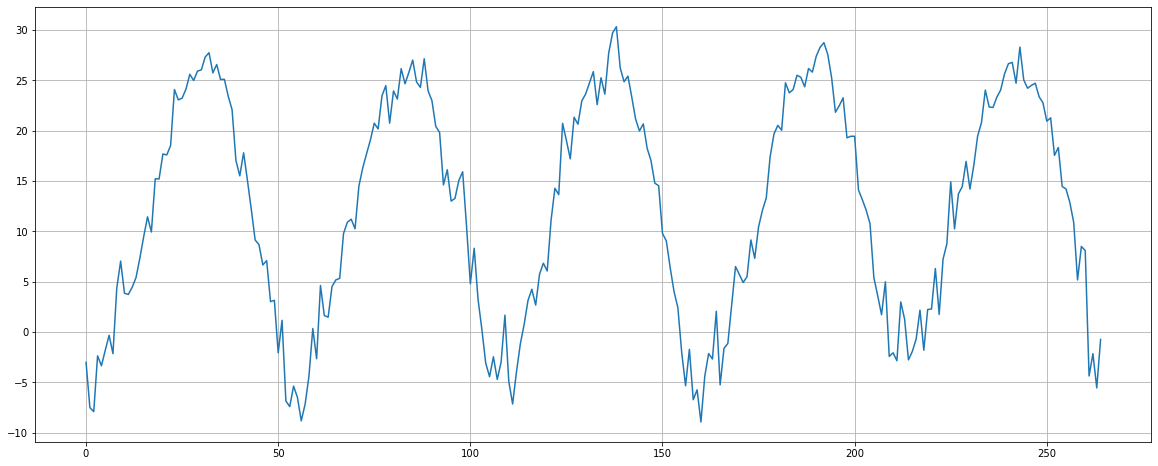

In [5]:
plt.figure(figsize = (20,8))
plt.plot(data.AvgTemp)
plt.grid()
plt.show()

##3.데이터 준비

### (1) y 만들기

In [6]:
data['y'] = data['AvgTemp'].shift(-1)
data.dropna(axis = 0, inplace = True)
data.head()

,year,week,AvgTemp,y
0,2010,1,-3.000000,-7.500000
1,2010,2,-7.500000,-7.900000
2,2010,3,-7.900000,-2.357143
3,2010,4,-2.357143,-3.342857
4,2010,5,-3.342857,-1.800000


### (2) x, y 분리

In [7]:
x = data.loc[:, ['AvgTemp']]
y = data.loc[:,'y']

### (3) 스케일링

In [8]:
scaler = MinMaxScaler()
x = scaler.fit_transform(x)

In [9]:
x.shape, y.shape

((264, 1), (264,))

### (4) 3차원 구조 만들기

In [10]:
# 4개 데이터씩 묶기 때문에 데이터 개수 3개 줄어듬 
x2, y2 = temporalize(x, y, 4)
x2.shape, y2.shape

((261, 4, 1), (261,))

In [11]:
x2

array([[[0.15106693],
        [0.0364937 ],
        [0.02630941],
        [0.16743453]],

       [[0.0364937 ],
        [0.02630941],
        [0.16743453],
        [0.14233754]],

       [[0.02630941],
        [0.16743453],
        [0.14233754],
        [0.18161979]],

       ...,

       [[0.35948109],
        [0.4442289 ],
        [0.43368089],
        [0.11651309]],

       [[0.4442289 ],
        [0.43368089],
        [0.11651309],
        [0.1728904 ]],

       [[0.43368089],
        [0.11651309],
        [0.1728904 ],
        [0.08632396]]])

In [12]:
x2[:2]

array([[[0.15106693],
        [0.0364937 ],
        [0.02630941],
        [0.16743453]],

       [[0.0364937 ],
        [0.02630941],
        [0.16743453],
        [0.14233754]]])

In [13]:
y[:7], y2[:2]

(0   -7.500000
 1   -7.900000
 2   -2.357143
 3   -3.342857
 4   -1.800000
 5   -0.314286
 6   -2.142857
 Name: y, dtype: float64,
 array([-3.34285714, -1.8       ]))

### (5) 데이터 분할

In [15]:
# shuffle = False : 랜덤 분할 하지마라
x_train, x_val, y_train, y_val = train_test_split(x2, y2, test_size= 53, shuffle = False)

In [16]:
x_train.shape, y_train.shape

((208, 4, 1), (208,))

In [17]:
x_val.shape, y_val.shape

((53, 4, 1), (53,))

## 4.RNN : 무작정 모델링

### (1) 입력 구조(shape)
* 분석 단위 : 2차원 ( timesteps, nfeatures)

In [18]:
x_train.shape

(208, 4, 1)

In [19]:
timestep = x_train.shape[1]
nfeatures = x_train.shape[2]

### (2) 모델 구조 설계
* 다음 구조를 그대로 설계해 봅시다.
    * SimpleRNN(8, input_shape = (timestep, nfeatures))
    * Dense(1)

In [20]:
clear_session()

model = Sequential([SimpleRNN(8, input_shape=(timestep,nfeatures)),
                    Dense(1, )])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 80        
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


### (3) 컴파일 및 학습
* 다음 조건으로 학습해 봅시다.
    * epochs = 100
    * learning_rate = 0.01

In [21]:
model.compile(optimizer=Adam(lr=0.01),loss='mse')
history = model.fit(x_train, y_train, epochs=100, validation_split=0.2).history

C:\Users\User\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/100
6/6 [==============================] - 2s 82ms/step - loss: 224.1824 - val_loss: 281.8385
Epoch 2/100
6/6 [==============================] - 0s 13ms/step - loss: 204.5982 - val_loss: 259.7473
Epoch 3/100
6/6 [==============================] - 0s 13ms/step - loss: 191.3848 - val_loss: 241.4535
Epoch 4/100
6/6 [==============================] - 0s 11ms/step - loss: 180.1092 - val_loss: 225.6926
Epoch 5/100
6/6 [==============================] - 0s 9ms/step - loss: 169.8596 - val_loss: 212.2253
Epoch 6/100
6/6 [==============================] - 0s 12ms/step - loss: 160.3181 - val_loss: 200.8982
Epoch 7/100
6/6 [==============================] - 0s 9ms/step - loss: 149.3307 - val_loss: 192.0272
Epoch 8/100
6/6 [==============================] - 0s 12ms/step - loss: 139.9843 - val_loss: 180.6733
Epoch 9/100
6/6 [==============================] - 0s 9ms/step - loss: 130.4216 - val_loss: 169.4004
Epoch 10/100
6/6 [==============================] - 0s 13ms/step - loss: 123.8646 - v

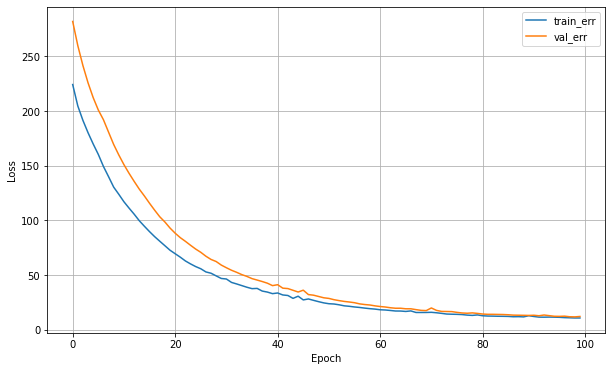

In [24]:
# 학습 곡선을 그려봅시다.
dl_history_plot(history)

### (4) 예측 및 평가

In [25]:
# 예측
pred = model.predict(x_val)

2/2 [==============================] - 0s 3ms/step


In [26]:
# 평가
print(mean_absolute_error(y_val, pred))
print(mean_absolute_percentage_error(y_val, pred))

3.0040804437157895
0.6888482685230203


In [ ]:
# 예측한 기온과 실제 기온의 차이가 평균+- 3도 차이난다

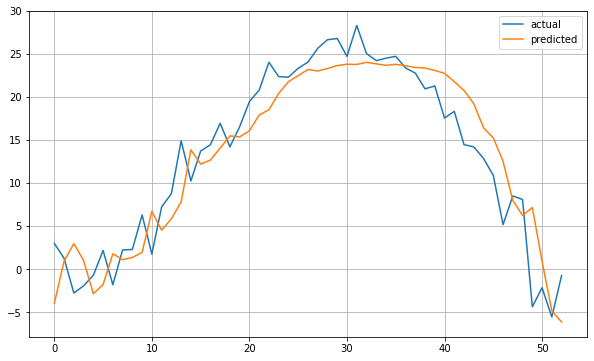

In [27]:
plt.figure(figsize = (10,6))
plt.plot(y_val, label = 'actual')
plt.plot(pred, label = 'predicted')
plt.legend()
plt.grid()
plt.show()

## 5.RNN 모델링②

### (1) 입력 구조(shape)
* 분석 단위 : 2차원 ( timesteps, nfeatures)

In [ ]:
timestep = x_train.shape[1]
nfeatures = x_train.shape[2]

### (2) 모델 구조 설계
* 이제 RNN 레이어를 추가해 봅시다.
    * SimpleRNN(8, input_shape = (timestep, nfeatures), return_sequences = True)
    * SimpleRNN(4)
    * Dense(1)

### (3) 컴파일 및 학습
* 학습을 위한 조건은 직접 조정해 봅시다.

### (4) 예측 및 평가

## 6.RNN 모델링③
* 5번 모델의 SimpleRNN을 LSTM 로 이름만 바꿔봅시다.

### (1) 데이터 준비

* timestep 

In [ ]:
timestep = 
x2, y2 = temporalize(x, y, timestep)
x2.shape, y2.shape

* 데이터 분할

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x2, y2, test_size= 53, shuffle = False)

### (2) 입력 구조(shape)
* 분석 단위 : 2차원 ( timesteps, nfeatures)

In [ ]:
timestep = x_train.shape[1]
nfeatures = x_train.shape[2]

### (3) 모델 구조 설계


### (4) 컴파일 및 학습

### (5) 예측 및 평가

## 7.자유롭게 모델링~!
* 다음 항목을 조정하며 모델링을 수행해 봅시다.
    * timestep
    * 레이어와 노드수
    * learning_rate, epochs


### (1) 데이터 준비

* timestep 

In [ ]:
timestep = 
x2, y2 = temporalize(x, y, timestep)
x2.shape, y2.shape

* 데이터 분할

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x2, y2, test_size= 53, shuffle = False)

### (2) 입력 구조(shape)
* 분석 단위 : 2차원 ( timesteps, nfeatures)

In [ ]:
timestep = x_train.shape[1]
nfeatures = x_train.shape[2]

### (3) 모델 구조 설계


### (4) 컴파일 및 학습

### (5) 예측 및 평가